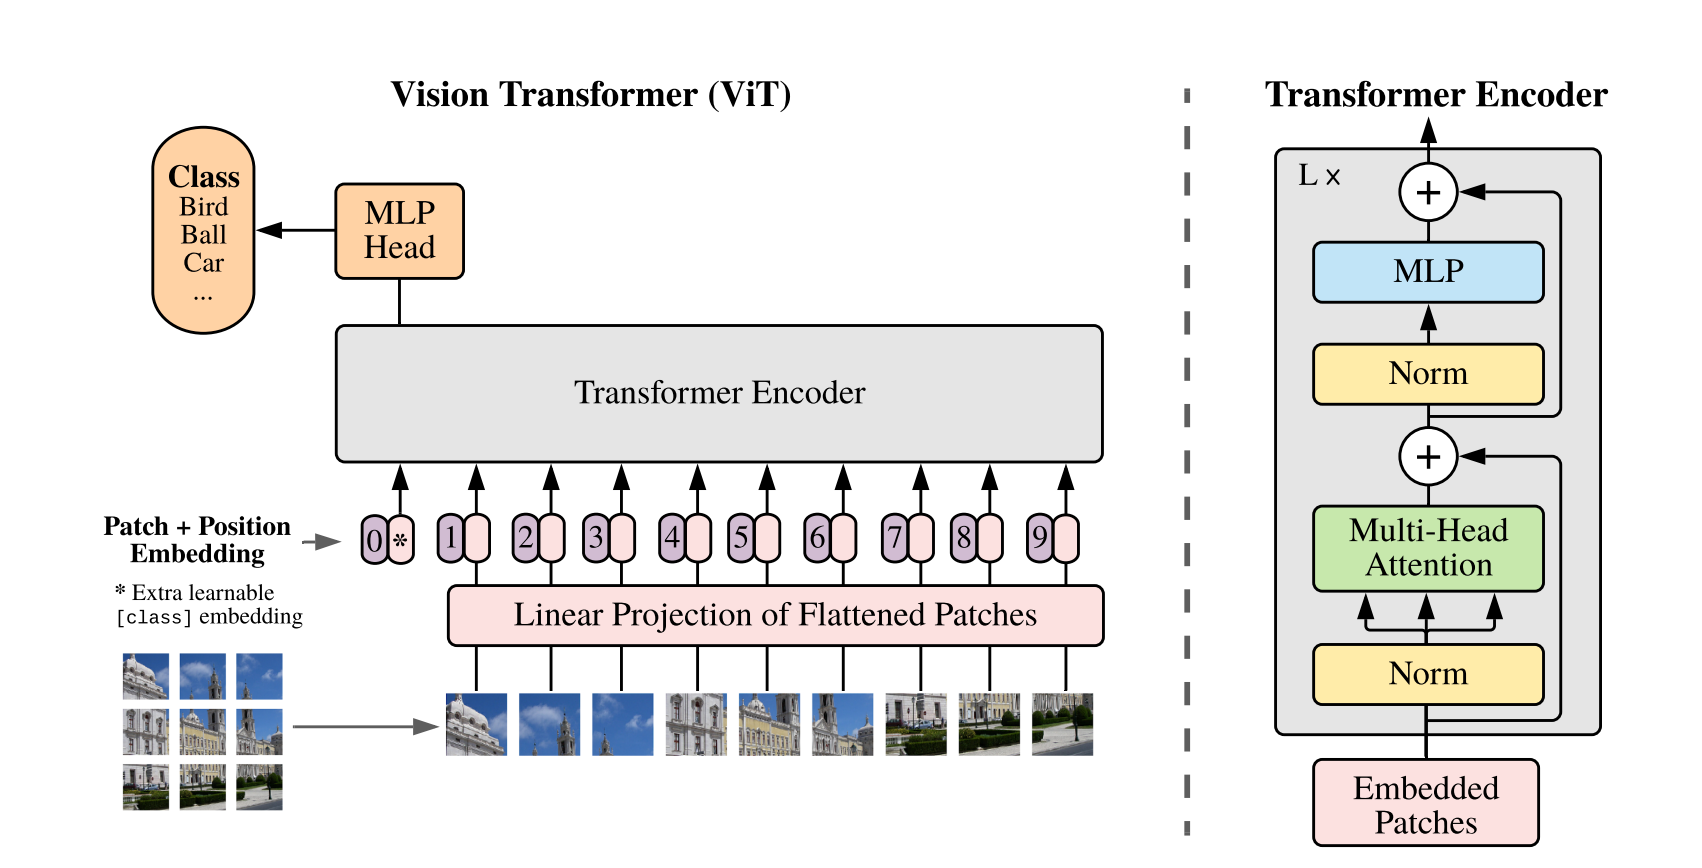

**第一部分：将图形转化为序列化数据**    
·将图片划分成**9个patch**，然后将每个patch展平，得到flattened patch    
·图片维度:**HxWxC**，使用**PxP**大小的patch去分割图片得到**N**个patch，每个patch就是**PxPxC**，将N个patch就是NxPxPxC   
·对flattened patch做linear projection，将flattened patch转化成固定长度的向量，综上得到了N个D维的向量(**NxD**)

**第二部分:position embedding**     
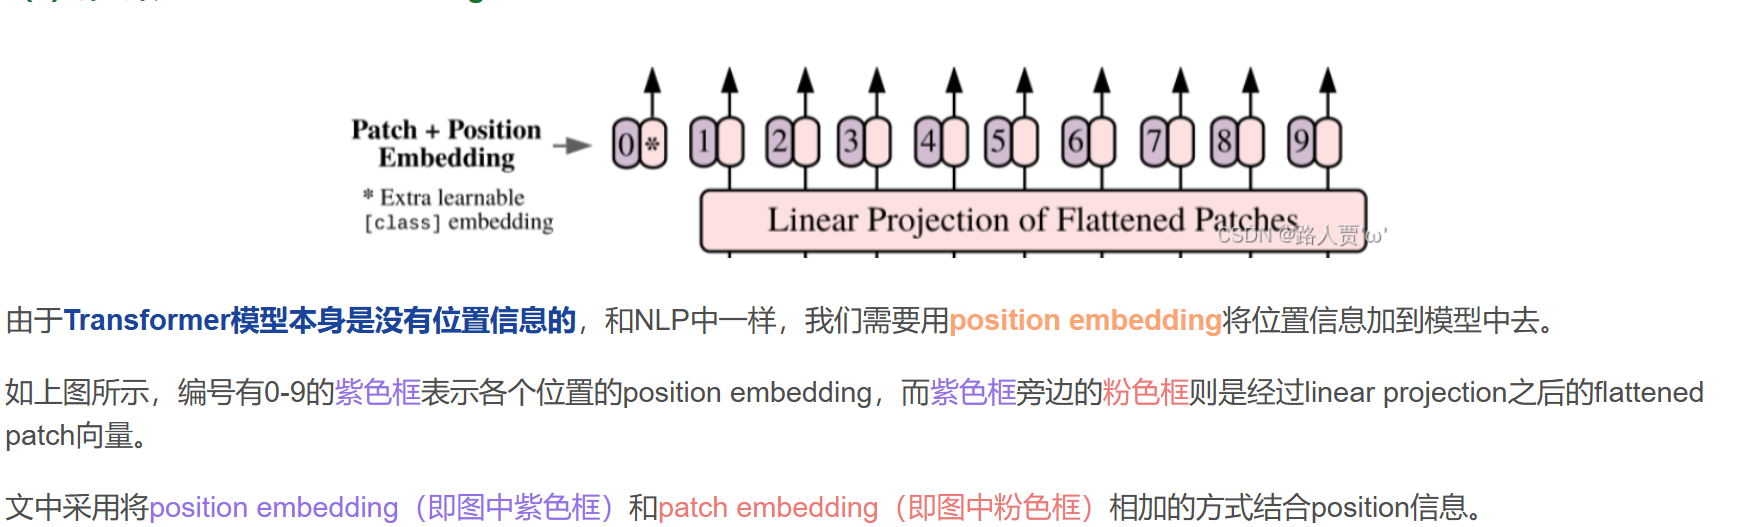

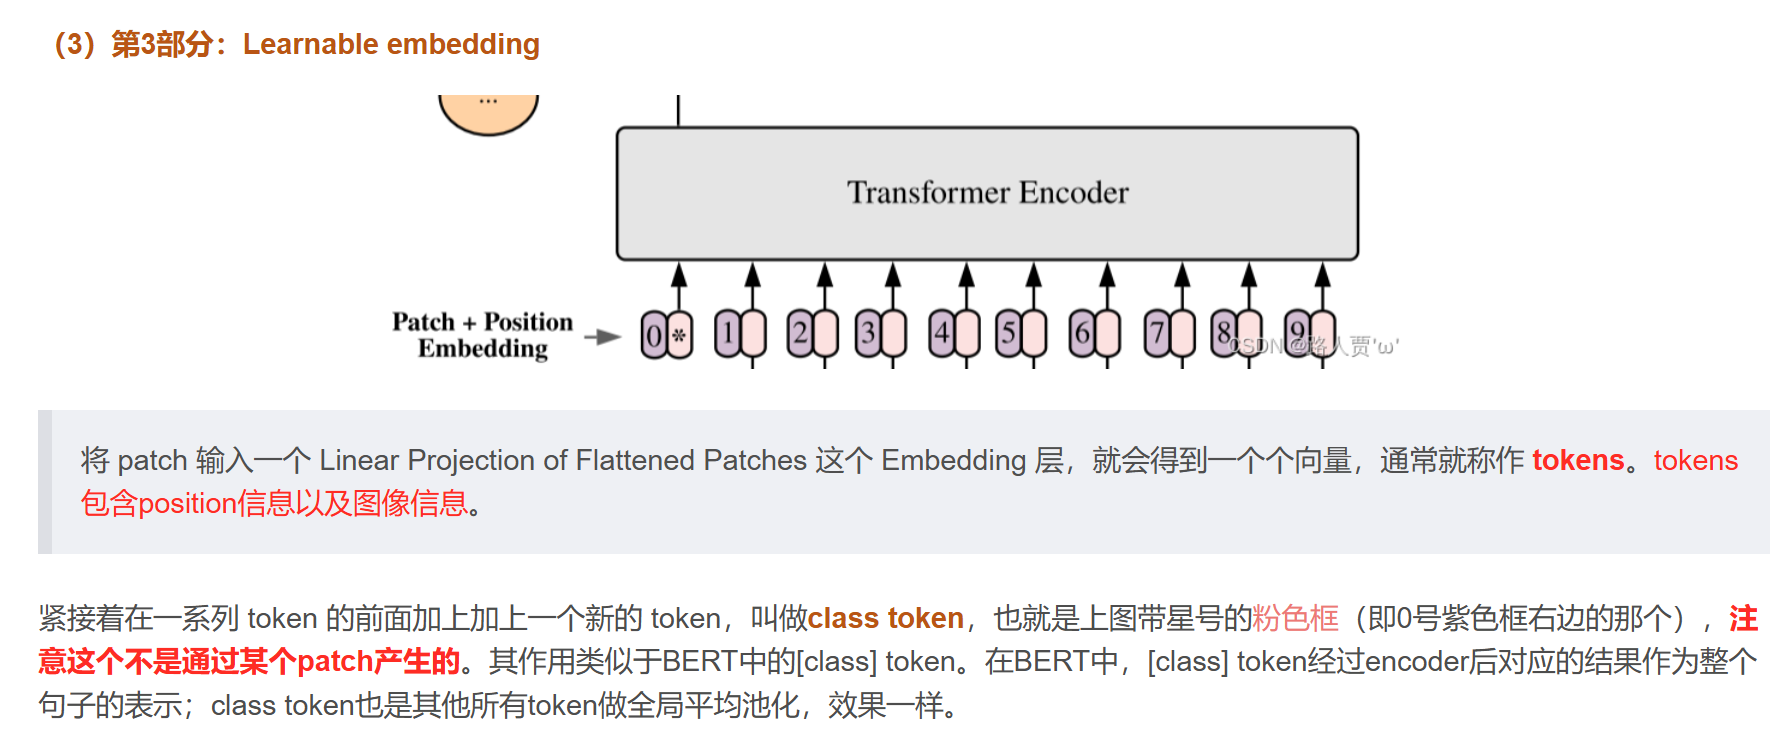

具体效果：

每个token的特征均值接近0，方差接近1
加速收敛，允许使用更大学习率
减少对初始化的依赖
提高模型泛化能力

In [5]:
import torch
from torch import nn
#======================3.PreNorm=============================#
# 规范化层的类封装
class PreNorm(nn.Module):
    '''
    :param  dim 输入和输出维度
            fn 前馈网络层，选择Multi-Head Attn和MLP二者之一
    '''
    def __init__(self, dim, fn):
        super().__init__()
        # LayerNorm: ( a - mean(last 2 dim) ) / sqrt( var(last 2 dim) )
        # 数据归一化的输入维度设定，以及保存前馈层
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    # 前向传播就是将数据归一化后传递给前馈层
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [6]:
#======================4.FeedForward=============================#
# FFN
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
 
    def forward(self, x):
        return self.net(x)

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = heads * dim_head
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        #sqrt(dim_head)用于消除误差，保证方差为1，避免向量内积过大导致softmax将许多输出变为0
        self.scale = dim_head ** 0.5
        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transposr(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

**--------------------------------------------------------------------------------------------------**

**VIT**
VIT encoder中，可以任务multi-head self-attention是空间融合，FNN是通道融合     
引入归纳偏置少，所以表现好，对数据量要求大     
相较于cnn，vit是全局特征而不是局部特征

In [ ]:
|